# Assignment XX - Self Organizing Maps


## Authors
B.W. Holwerda

## Learning Goals
* introduction to a second "machine learning" classifying algorithm
* Identifying features in data
* Unsupervised Machine Learning
* Green Valley Galaxies
* Interstitial Populations
* quantization error (QE). 
* topographical error (TE)


## Keywords
python, syntax, jupyter notebook, matplotlib, scatter, log plot, scikit-learn, Self Organizing Maps, SOM

## Companion Content

## Summary
This assignment teaches how to apply the SOM algorithm to real data and evaluate its effectiveness.

<hr>

## Student Name and ID:



## Date:

<hr>


And the k-clustering sample from Turner et al: https://ui.adsabs.harvard.edu/abs/2019MNRAS.482..126T

The GAMA data is organized as follows:

 * 0 - GAMA CATAID
 * 1 - Stellar mass (log10 solar masses)
 * 2 - u-r color
 * 3 - S'ersic index (log10)
 * 4 - Half-light radius (log10 kpc)
 * 5 - Specific star formation rate (log10 Gyr^-1)

Please note that all these values are logarithmic! 

In [58]:
# import the minisom stuff we need
from minisom import MiniSom
# sklearn for scaling the data
from sklearn.preprocessing import scale
# Import matplotlib and numpy of course
import matplotlib.pyplot as plt
import numpy as np
# Import the `pandas` library as `pd`
import pandas as pd

In [93]:
gama = pd.read_csv("mstar_ur_n_hlr_ssfr_tl.csv", header=None, names=['gamaid','mstar','u-r','sersicn','r50','ssfr'])

kclusters = pd.read_csv("mstar_ur_n_hlr_ssfr_tlz_k2356.csv", header=None, names=['gamaid','k2','k3','k5','k6'])



# Import
gama_features = gama[['mstar','u-r','sersicn','r50','ssfr']]

# Apply `scale()` to the gama data
data = scale(gama_features)
# print(data)

n_samples, n_features = data.shape
print(n_samples)

# Print out `n_features`
print(n_features)



[[ 0.03344232 -0.28056153 -0.71398076 -0.99919735  0.31432967]
 [-1.69021754 -2.09090418  2.30104743 -1.66052425  1.08478931]
 [-1.43019756 -0.89145617 -0.86921062 -0.87512778  0.61299953]
 ...
 [-0.52381956 -0.61068462 -0.53418579  0.26215322  0.24424211]
 [ 0.78668911 -0.31280501 -0.14639222  0.51553364  0.3636743 ]
 [-0.61675723 -0.87561798  0.36174014 -0.32442846  0.77306311]]
7338
5


### Initializing the SOM

Now it is time to initialize our Self Organizing Map i.e. seed it with random values with 5 features of the GAMA data. 

In [76]:
size = 100

# Initializing the SOM
som = MiniSom(size, size, 5, sigma=3., 
              learning_rate=2.5, 
              neighborhood_function='gaussian')

### There is no split into a train and test sample!

A SOM is unsupervised learning, meaning that we train the SOM on the entire data-set and then apply labels afterwards. 

There is no stopping you from splitting the sample anyway and using a subset to test the SOM labels with later. 

In [77]:
som.train(data, 5000, random_order=True, verbose=True)

# plt.imshow(abs(som.get_weights()), interpolation='none')

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 0.3699649603170845


### Which features are where on the map?

How is each feature distributed over the map. 

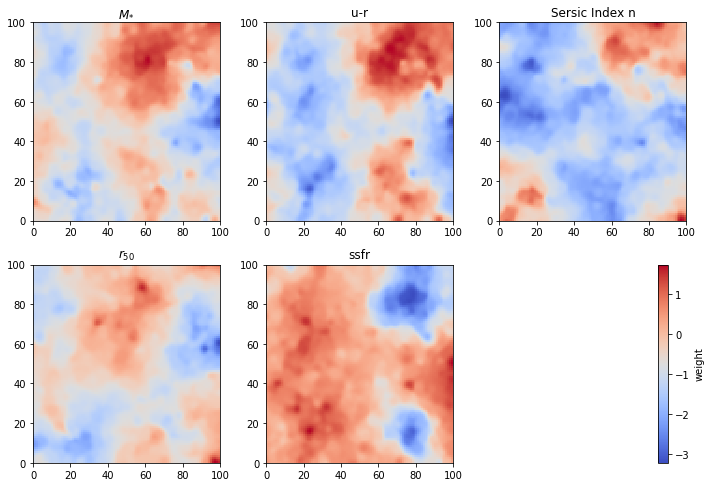

In [86]:
feature_names = ['$M_{*}$','u-r','Sersic Index n','$r_{50}$','ssfr']
W = som.get_weights()
plt.figure(figsize=(10, 10))
for i, f in enumerate(feature_names):
    plt.subplot(3, 3, i+1)
    plt.title(f)
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
    #plt.xticks(np.arange(size+1))
    #plt.yticks(np.arange(size+1))
plt.subplot(3, 3, 6)
plt.axis('off')
plt.colorbar(label='weight')
plt.tight_layout()
plt.savefig('som_features.png')
plt.savefig('som_features.pdf')

plt.show()

### Exercise 1 

Which maps looks the same or the inversion of another (and therefore trace the same thing)?

Which two features look like they are redundand and one could do without?

*student answer here*

### Exercise 2 

Let's look where the different K-means clustering from Turner et al. (2018) end up on the SOM. 

There are four columns we can use as labels. K2 means two K-means cluster, K3 three and so on. 


0
1


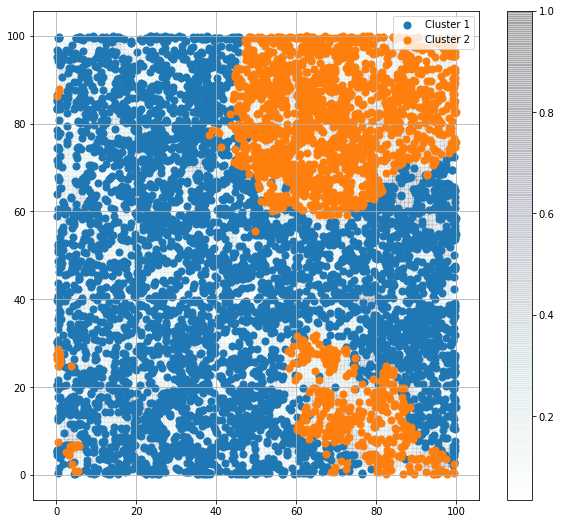

In [89]:

target = kclusters['k2'].values
label_names = {0:'Cluster 1', 1:'Cluster 2'}

# target = kclusters['k3'].values
# label_names = {0:'Cluster 1', 1:'Cluster 2', 2:'Cluster 3'}

# target = kclusters['k5'].values
# label_names = {0:'Cluster 1', 1:'Cluster 2', 2:'Cluster 3', 3:'Cluster 4', 4:'Cluster 5'}

# target = kclusters['k6'].values
# label_names = {0:'Cluster 1', 1:'Cluster 2', 2:'Cluster 3', 3:'Cluster 4', 4:'Cluster 5', 5:'Cluster 6'}

w_x, w_y = zip(*[som.winner(d) for d in data])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(10, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(target):
    idx_target = target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c='C%d' % c, label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.savefig('som_seed.png')
plt.show()

### Exercise 2

Is there a good separation of K-means clusters in the SOM?

*student answer here*

### Exercise 3

Does the SOM organize any of the K-means clusters together? 

*student answer here*

### Mapping the K-mean clusters onto the SOM

Does the SOM organize along the same lines as the K-means clusters.

We can look at each node in the SOM and visualize the fraction of each K-means cluster in each.

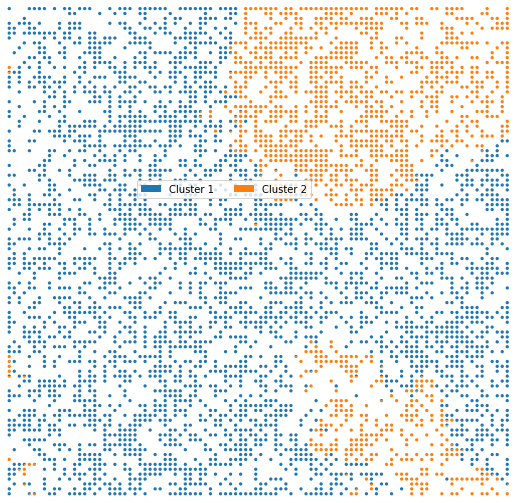

In [91]:
import matplotlib.gridspec as gridspec

target = kclusters['k2'].values
label_names = {0:'Cluster 1', 1:'Cluster 2'}

# target = kclusters['k3'].values
# label_names = {0:'Cluster 1', 1:'Cluster 2', 2:'Cluster 3'}

# target = kclusters['k5'].values
# label_names = {0:'Cluster 1', 1:'Cluster 2', 2:'Cluster 3', 3:'Cluster 4', 4:'Cluster 5'}

# target = kclusters['k6'].values
# label_names = {0:'Cluster 1', 1:'Cluster 2', 2:'Cluster 3', 3:'Cluster 4', 4:'Cluster 5', 5:'Cluster 6'}



labels_map = som.labels_map(data, [label_names[t] for t in target])

n_neurons = m_neurons = size

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(n_neurons, m_neurons, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[n_neurons-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names.values(), bbox_to_anchor=(3.5, 6.5), ncol=3)
plt.savefig('som_seed_pies.png')
plt.show()

### Exercise 4

Do this visualization for the k2 and k6 nodes. 

What do you notice? Are there nodes on the map that correspond to a single K-mean cluster? How are they blended? Are K-means and SOM good ways to map groupings in a multi-dimensional space?

*student answer here*

### Green Valley Galaxies

One of the bimodalities that motivated the K-means clustering exercise by Turner+ (2018) is color. In this case, one expects a blue and red group of galaxies and 

Bremer+ (2018) defines the red and blue groupings as:

$ u-r > 0.2*(log10(M_*) - 10) + 1.5 $

and the blue cloud as:

$ u-r < 0.1*(log10(M_*) - 10) + 1.3 $ 

and the green valley galaxies as lying in between.

Note please that they only defined this in a narrow range of stellar mass. But we can for our purposes use it over the full range. 


### Exercise 5

Plot the u-r color against the stellar mass, marking the three color groups. Do they look like clusters or groupins we saw in the K-means clustering?



In [1]:
# student work here


*student answer here*

### Exercise 6

Map the green, red and blue galaxies onto the SOM we have trained earlier. 
HINT: start with the code above Exercise 2

Make an array where each gama galaxy is labeled 0 (green), 1 (red) and blue (2) using the above criteria.
Then make sure these points get the corresponding colors using a separate array of color strings.



In [2]:
# student work here.


### Exercise 7

Where do the red, blue and green galaxies end up? 

*student answer here*

### Exercise 8

The "Green Valley" has famously been called "a red herring". From your mapping of these green valley galaxies onto the SOM, do they strike you as an "interstitial" or transitional subsample? 

Use the SOM map to motivate your answer. 

*student answer here*

### Errors

You will have noticed that the discriminatory power of the SOM depends completely on how long it's been trained and how big the map is. 

To get a *feel* for how good the SOM is doing and what a resonable size and number of iterations is, we can explore the two error parameters it also returns: quantization and topographic error.

from:
https://www.intechopen.com/books/sustainability-in-urban-planning-and-design/improving-feature-map-quality-of-som-based-on-adjusting-the-neighborhood-function

To evaluate the quality of feature map, we use two indicators: learning quality and projection quality. 
The learning quality indicator is determined through measurement of quantization error (QE). 
The projection quality indicator is determined through measurement of topographical error (TE)

Quantization error and topographical error are main measurements to assess the quality of SOM. Quantization error is the average difference of the input samples ($x(t)$) compared to its corresponding winning neurons ($w(t)$). It assesses the accuracy of the represented data, therefore, it is better when the value is smaller.

$$ QE = {1 \over T} \Sigma_{t=1}^T || x(t)  - W(t) || $$

where x(t) is the input sample at the training t; wc(t) is the BMU’s weight vector of sample x(t); T is total of training times.

The topografical error indicates the number of the data samples having the first best matching unit (BMU1) and the second best matching unit (BMU2) being *not* adjacent. 

$$ TE = {1 \over T} \Sigma_{t=1}^T d(x(t)) $$

where x(t) is the input sample at training times t; d(x) is a step function where, d(x(t)) = 1 if BMU1 and BMU2 of x(t) not adjacent and  d(x(t)) = 0; T is total of training times.

We will now run through a small SOM for 1000 iterations (this may take a bit of time...) 
and plot these two quantities.


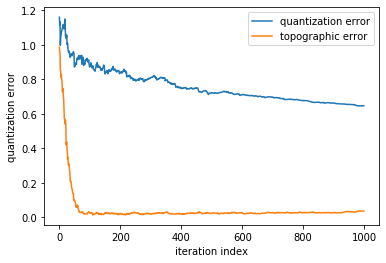

In [101]:
size = 30

som = MiniSom(size, size, data.shape[1], sigma=3., learning_rate=.7,
              neighborhood_function='gaussian', random_seed=10)

max_iter = 1000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(data))
    som.update(data[rand_i], som.winner(data[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(data))
    t_error.append(som.topographic_error(data))

plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('quantization error')
plt.xlabel('iteration index')
plt.legend()
plt.show()

### Exercise 9

With a size of 30, is a 1000 iterations not enough, too much, or just right? Motivate your answer.


*student answer here*

### Exercise 10

Which error converges first? Can you think of a reason why? 


*student answer here*

### Exercise 11 (BONUS)

We did not split the sample into a training and test sample but there is nothing stopping us. 

Using sklearn's train_test_split, split the SOM input data into halves. 

Plot the *whole* data set with K2 labels to see how two, otherwise identically trained but one on half the data
performs. Remember that because a SOM is randomly seeded, the SOM maps will look differently!

In [3]:
# student work here